train
 (50000, 32, 32, 3) (50000, 1)
(25000, 32, 32, 3) (25000, 1)
test
 (10000, 32, 32, 3) (10000, 1)
(5000, 32, 32, 3) (5000, 1)


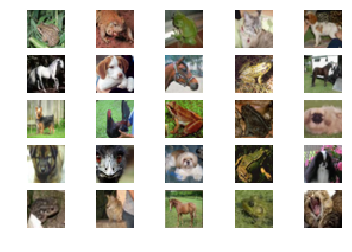

In [2]:
from __future__ import print_function
import keras
from keras.models import Model
from keras.datasets import cifar10
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import callbacks
import os
from keras.models import load_model
from keras.utils.vis_utils import plot_model
import h5py
from keras.utils import multi_gpu_model
import argparse
from matplotlib import pyplot as plt
from matplotlib import pyplot as plt2
from matplotlib.colors import Normalize
from keras import backend as K
from IPython.display import clear_output
from keras.preprocessing import image
from PIL import Image
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split
import numpy as np

def resize_to_input_and_save(input_image_path,
                                output_image_path,
                                size):   
    
    # Reads the image and resize it 
    resized_image = image.load_img(input_image_path, target_size=size)
    # Saves the resized image in the wnated path
    resized_image.save(output_image_path)
    
    # Gets the img as a numpy array
    img_array = image.img_to_array(resized_image) 
    
#   Normalize the pixel to be between [0,1] for the prediction
    img_array /= 255
    
    # Just to show the image
    plt.imshow(img_array)
    plt.show()
    
    # reshape the array so it will fit the input of the model
    # (number of samples, rows, cols, dimentions(3 cuz rgb)) 
    img_array = np.expand_dims(img_array, axis=0)

    print('Input image shape:', img_array.shape)

    return (img_array)

# Callsbacks
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        
        self.fig = plt.figure()
        self.fig2 = plt2.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        plt2.plot(self.x, self.acc, label="acc")
        plt2.plot(self.x, self.val_acc, label="val_acc")
        plt2.legend()
        plt2.show();
        
plot_losses = PlotLosses()

# Path to save thebest checkpoint
filepath="best_model-{epoch:03d}-{val_loss:.4f}-{val_acc:.4f}.hdf5"

# Callback to save the best checkpoint comparing the validation set loss
checkpoint = callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# Callback to stop learning if the validation loss isnt improving
early_stopping=callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, verbose=1, mode='min')
# End of callbacks


%matplotlib inline

CIFAR10_NAMES = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]
CIFAR10_NAME_TO_NUMBER = dict(zip(CIFAR10_NAMES, range(len(CIFAR10_NAMES))))

wanted_classes = ["dog", "cat", "bird", "horse", "frog"]
wanted_classes_numbers = [CIFAR10_NAME_TO_NUMBER[name] for name in wanted_classes]

shrink_data = True
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

if shrink_data:
    selected_classes = wanted_classes_numbers
    print('train\n', x_train.shape, y_train.shape)
    x = [ex for ex, ey in zip(x_train, y_train) if ey in selected_classes]
    y = [selected_classes.index(ey) for ex, ey in zip(x_train, y_train) if ey in selected_classes]
    x_train = np.stack(x)
    y_train = np.stack(y).reshape(-1,1)
    print(x_train.shape, y_train.shape)

    print('test\n', x_test.shape, y_test.shape)
    x = [ex for ex, ey in zip(x_test, y_test) if ey in selected_classes]
    y = [selected_classes.index(ey) for ex, ey in zip(x_test, y_test) if ey in selected_classes]
    x_test = np.stack(x)
    y_test = np.stack(y).reshape(-1,1)
    print(x_test.shape, y_test.shape)
    num_classes = len(selected_classes)
else:
    print('train\n', x_train.shape, y_train.shape)
    print('test\n', x_test.shape, y_test.shape)
    num_classes = 10

# Normalize the data   
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255    
    
# show some images
plt.figure(1)
for i in range (1,26):
    ax = plt.subplot(5,5,i)
    ax.axis('off')
    ax.imshow(x[i].reshape(32,32,3))
plt.show()

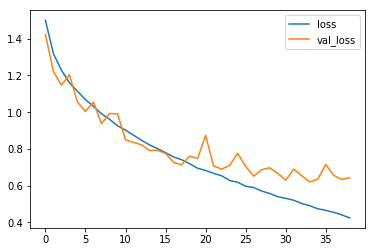

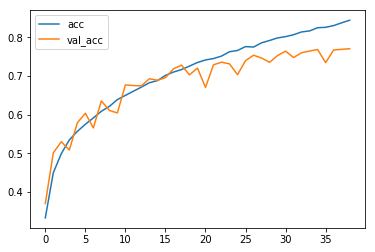

Epoch 00039: val_loss did not improve
22500/22500 [==============================] - 5s 209us/step - loss: 0.4239 - acc: 0.8444 - val_loss: 0.6428 - val_acc: 0.7708
Epoch 00039: early stopping
5000/5000 [==============================] - 2s 425us/step
==> Test loss: 0.661198562765
==> Test accuracy: 0.7552


In [159]:
batch_size = 200
epochs = 120

# The data, shuffled and split between train and test sets:
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=x_train.shape[1:],
          activation='relu', name='input'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (5, 5),activation='relu', padding='same'))
model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(512, activation='relu',name='FC1'))
model.add(Dense(512, activation='relu',name='FC2'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax', name='output'))

# initiate RMSprop optimizer
rmsprop = keras.optimizers.rmsprop(lr=0.0002, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=rmsprop,
              metrics=['accuracy'])

# Callbacks:
# plot_losses - prints the loss and accuracy at end of every epoch
# checkpoint - saves the best model we managed to generate
# early_stopping - stops the training when we are not getting better
history = model.fit(x_train, y_train,  # this is our training examples & labels
                      batch_size=batch_size,
                      epochs=epochs,
                      validation_split=0.1,  # this parameter control the % of train data used for validation
                      shuffle=True,
                      callbacks=[plot_losses, checkpoint, early_stopping])  
    
# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('==> Test loss:', scores[0])
print('==> Test accuracy:', scores[1])

In [14]:
#----------------------------------Load best model--------------------------------------------------------
path = 'best_model/'

# Gets the name of the best model h5 file
best_model_name = [i for i in os.listdir(path) if os.path.isfile(os.path.join(path,i)) and 'best_model' in i]
print(best_model_name)

# returns the model by the path
model = load_model(os.path.join(path, best_model_name[0] ))

['best_model-039-0.6611-0.7552.h5']


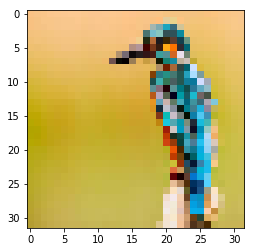

Input image shape: (1, 32, 32, 3)
[[  6.80033758e-04   1.68305065e-03   9.97309208e-01   3.23882014e-05
    2.95414036e-04]]
bird


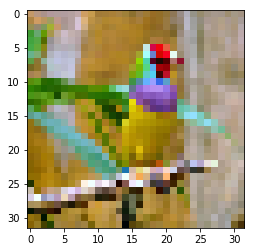

Input image shape: (1, 32, 32, 3)
[[  3.56339093e-04   2.33034752e-02   9.65559840e-01   1.53268818e-04
    1.06270947e-02]]
bird


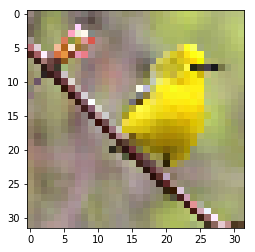

Input image shape: (1, 32, 32, 3)
[[  1.48358801e-03   3.24975029e-02   9.04592931e-01   1.44071557e-04
    6.12818487e-02]]
bird


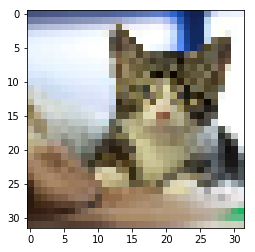

Input image shape: (1, 32, 32, 3)
[[ 0.0103064   0.96408004  0.00910713  0.0009833   0.01552302]]
cat


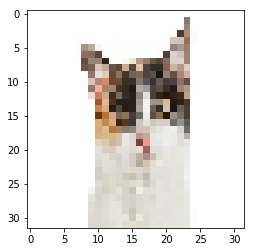

Input image shape: (1, 32, 32, 3)
[[ 0.15890488  0.8242619   0.00973131  0.00126782  0.00583404]]
cat


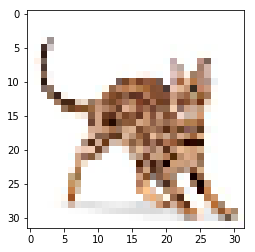

Input image shape: (1, 32, 32, 3)
[[  3.10806604e-03   9.06185985e-01   1.22988671e-02   5.85043279e-04
    7.78219476e-02]]
cat


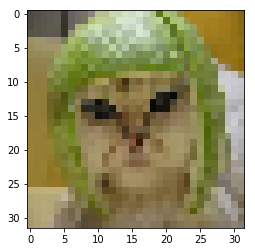

Input image shape: (1, 32, 32, 3)
[[ 0.01500258  0.07054208  0.07295612  0.00487418  0.83662498]]
frog


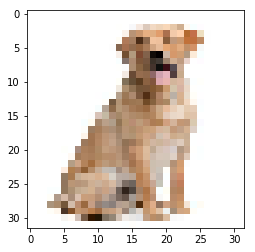

Input image shape: (1, 32, 32, 3)
[[ 0.4294787   0.27616301  0.08673421  0.18763849  0.01998561]]
dog


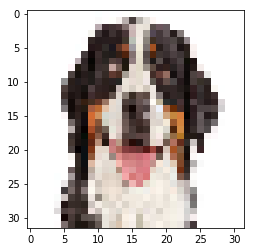

Input image shape: (1, 32, 32, 3)
[[ 0.76052165  0.04186466  0.00648201  0.18995547  0.00117622]]
dog


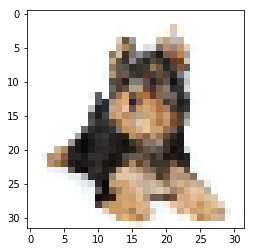

Input image shape: (1, 32, 32, 3)
[[ 0.28889543  0.57553893  0.056594    0.04330154  0.03567009]]
cat


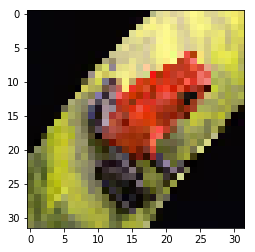

Input image shape: (1, 32, 32, 3)
[[ 0.02300181  0.01598843  0.02255005  0.00641515  0.93204457]]
frog


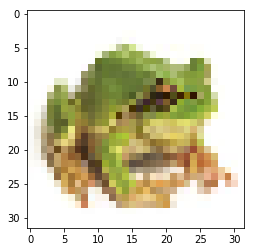

Input image shape: (1, 32, 32, 3)
[[  7.36836910e-06   1.79557805e-03   7.60842086e-05   3.69174984e-07
    9.98120606e-01]]
frog


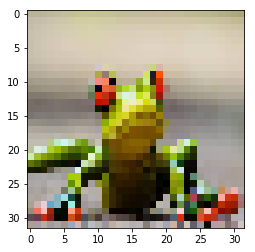

Input image shape: (1, 32, 32, 3)
[[ 0.00349961  0.04736976  0.13986835  0.00255463  0.80670768]]
frog


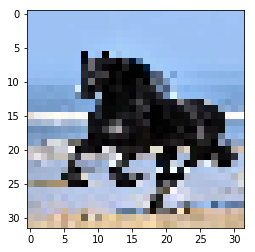

Input image shape: (1, 32, 32, 3)
[[ 0.03437959  0.25600392  0.04697482  0.64922011  0.01342161]]
horse


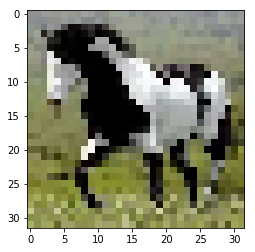

Input image shape: (1, 32, 32, 3)
[[  3.44106491e-04   1.32748712e-04   5.27934753e-04   9.98851418e-01
    1.43818397e-04]]
horse


In [15]:
#----------------------------------Predict my own images--------------------------------------------------------
img_dir = "images"
img_resize_dir = "img_resized"

for img in os.listdir(img_dir):
    img_path = os.path.join(img_dir, img)
    output_img_path = os.path.join(img_resize_dir, img)
    
    input_array = resize_to_input_and_save(input_image_path=img_path,
                                             output_image_path=output_img_path,
                                             size=(32, 32))
    
    result = model.predict(input_array)
    print(result)
    # Prints the name of the class, by getting the max prob from the prediction
    # which is returned as a list with 1 item which is the index
    # and using that index in the wanted classes list
    print(wanted_classes[np.argmax(result, axis=-1)[0]])

(3, 3, 3, 32)
(3, 3, 32)


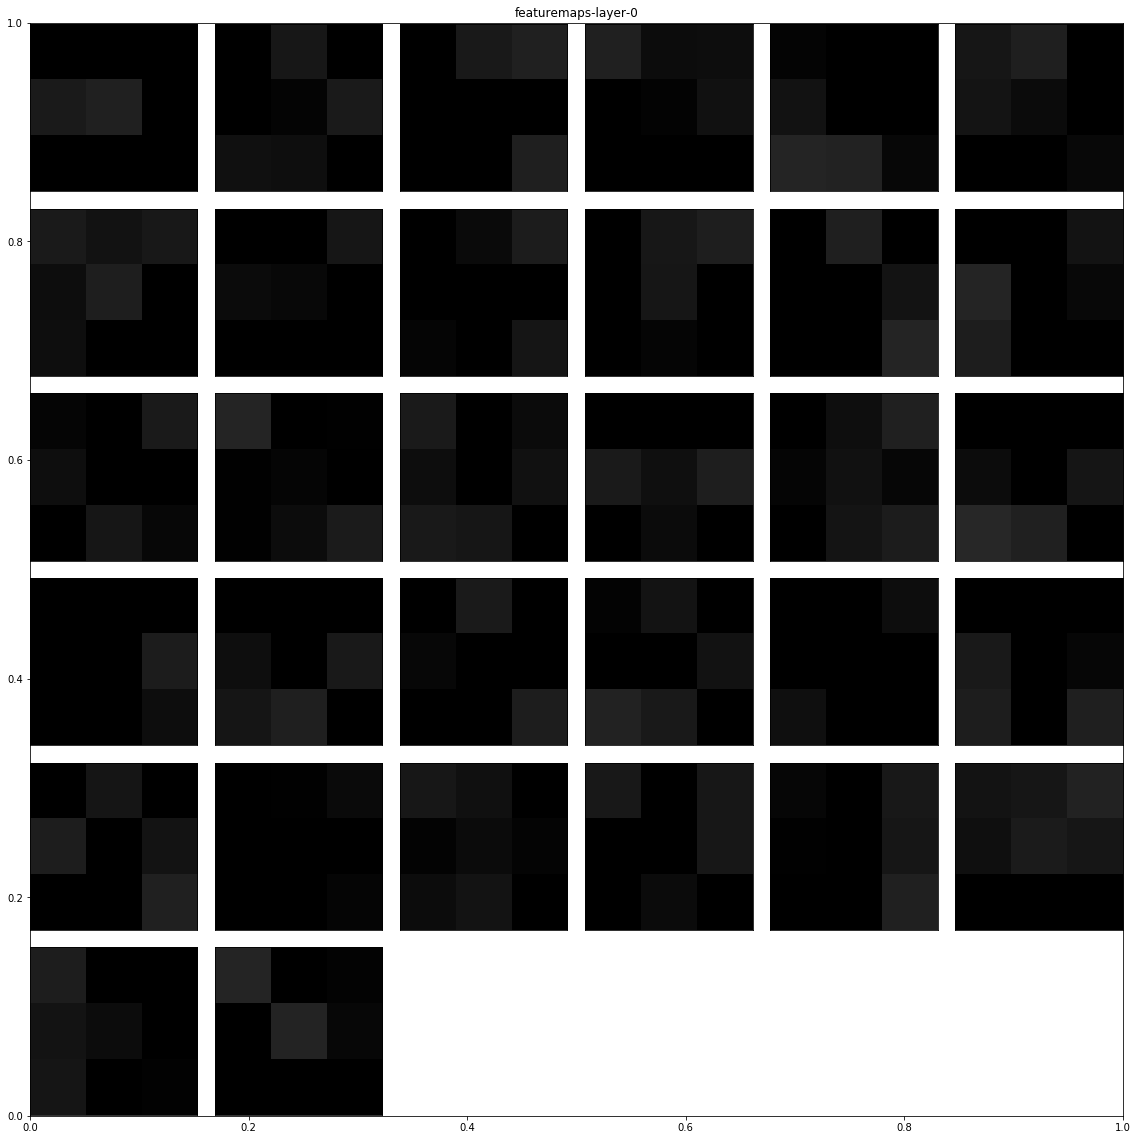

In [14]:
#----------------------------------Visualize Weights-------------------------------------------------------- 
layer_num = 0

first_layer = model.layers[layer_num]

weights = first_layer.get_weights()

filters = weights[0][:,:,0,:]

print(np.shape(weights[0]))
print(np.shape(filters))
# First param: row
# Second param: col
# Third param: filter number
# print(filters[:,:,:])


num_of_filters = filters.shape[2]
fig=plt.figure(figsize=(16,16))
plt.title("featuremaps-layer-{}".format(layer_num))
subplot_num=int(np.ceil(np.sqrt(num_of_filters)))
for i in range(num_of_filters):
    # Prepare a subplot of size subplot_num, subplot_num
    ax = fig.add_subplot(subplot_num, subplot_num, i + 1)
    # plots all the rows and col of filter in index i
    ax.imshow(filters[:,:,i] , norm=Normalize(0,1), interpolation="nearest", cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()


(1, 32, 32, 3)
(1, 1, 32, 32, 32)
(32, 32, 32)


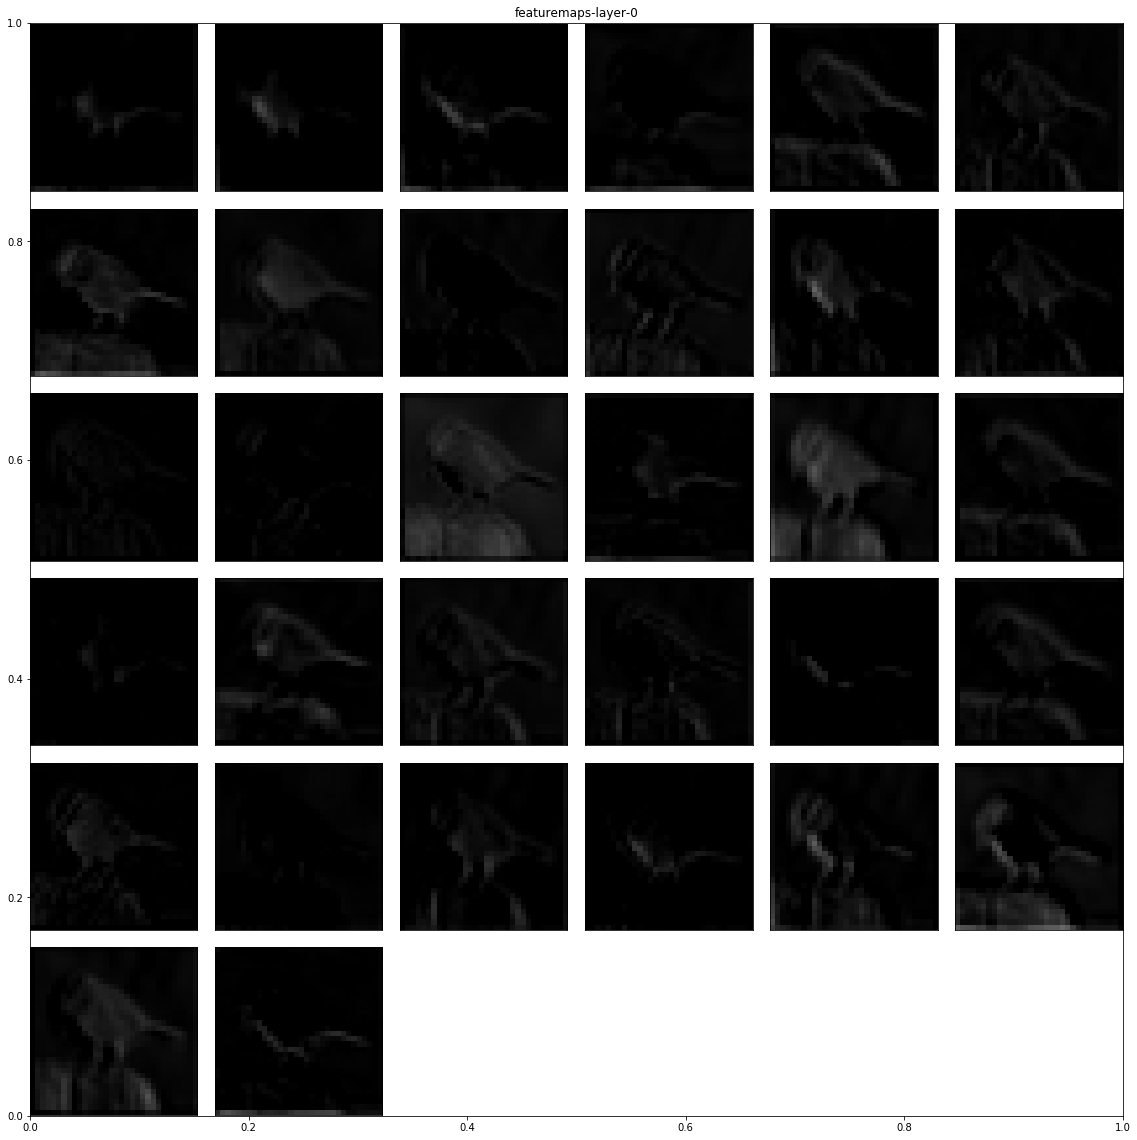

In [6]:
#----------------------------------Visualize activations--------------------------------------------------------    
def get_featuremaps(model, layer_idx, X_batch):
    get_activations = K.function([model.layers[0].input, K.learning_phase()],[model.layers[layer_idx].output,])
    activations = get_activations([X_batch,0])
    return activations    

layer_num=0
filter_num=0

# Takes a random picture shape is: (rows, cols, dimention)
test_image = x_test[159]
# Adds 1 as the sample amount as the first value so it will look like (1,32,32,3)
test_image= np.expand_dims(test_image, axis=0)
print (test_image.shape)

activations = get_featuremaps(model, int(layer_num),test_image)

print (np.shape(activations))
# Gets a structure like (rows, col, num of filters)
feature_maps = activations[0][0]      
print (np.shape(feature_maps))

# Gets the amount of filters
num_of_featuremaps=feature_maps.shape[2]
fig=plt.figure(figsize=(16,16))
plt.title("featuremaps-layer-{}".format(layer_num))
subplot_num=int(np.ceil(np.sqrt(num_of_featuremaps)))
for i in range(int(num_of_featuremaps)):
    ax = fig.add_subplot(subplot_num, subplot_num, i+1)
    #ax.imshow(output_image[0,:,:,i],interpolation='nearest' ) #to see the first filter
    ax.imshow(feature_maps[:,:,i], norm=Normalize(0,1), cmap='gray' )
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
plt.show()

In [16]:
#----------------------------------Create new model from prev model--------------------------------------------------------

# Creates the new model from the existing model configuration
# skipping all the layers untill the flatten layer included
new_model = Sequential.from_config(model.get_config()[:-5])

new_num_of_classes = 2

# Adds the new output layers
new_model.add(Flatten())
new_model.add(Dense(256, activation='relu'))
new_model.add(Dropout(0.5))
new_model.add(Dense(new_num_of_classes, activation='softmax', name='output'))

# Sets all the layers except for the new output layers as non trainable
for new_layer in new_model.layers[:-4]:
    new_layer.trainable = False

    
model.summary()
new_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_69 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 15, 15, 64)        51264     
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 11, 11, 64)        102464    
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 5, 5, 64)          0         
__________

(8189, 32, 32, 3)


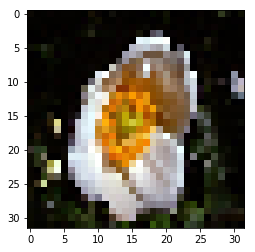

In [17]:
#----------------------------------Load flowers dataset and preapre data---------------------------------------------------
path='flowers_dataset/JPEG96'
flower_img_list=[]
for img in os.listdir(path):
    img_path = os.path.join(path, img)
    # Reads the image and resize it 
    flower_img = image.load_img(img_path, target_size=(32,32))
    flower_img_list.append(np.array(flower_img))

flower_dataset = np.asarray(flower_img_list) 
flower_dataset = flower_dataset.astype('float32')
flower_dataset /= 255
print (flower_dataset.shape)
# Just to show the image
plt.imshow(flower_dataset[8188])
plt.show()

[ 0.  1.]


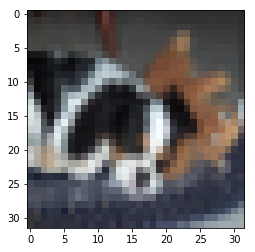

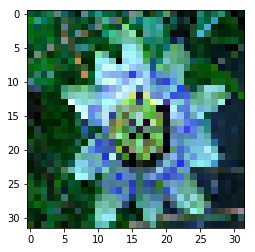

In [5]:
#----------------------------------Preapre data for new model---------------------------------------------------

# Concates the flower dataset with the cifar dataset
new_img_data = np.concatenate((flower_dataset, x_train[:flower_dataset.shape[0]]), axis=0)

# Gets the number of samples in the new dataset
num_of_samples = new_img_data.shape[0]

# Creates a labels list
labels = np.zeros((num_of_samples,),dtype='int64')

#0-flower, 1-Not a flower
labels[:flower_dataset.shape[0]] = 0
labels[flower_dataset.shape[0]:] = 1

# convert class labels to on-hot encoding
y_labels = keras.utils.to_categorical(labels, new_num_of_classes)

# Just prints the images to see 2 examples
print(y_labels[10000])
plt.imshow(new_img_data[10000])
plt.show()
plt.imshow(new_img_data[1])
plt.show()

#xf- pictures, yf- labels
#Shuffle the dataset
xf,yf = shuffle(new_img_data, y_labels, random_state=2)

# Split the dataset
xf_train, xf_test, yf_train, yf_test = train_test_split(xf, yf, test_size=0.2, random_state=2)

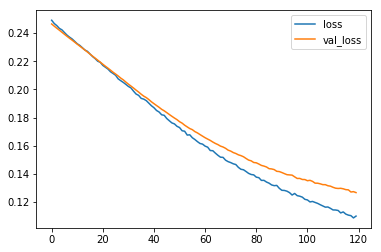

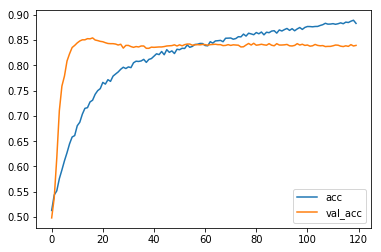

Epoch 00120: val_loss improved from 0.12715 to 0.12673, saving model to best_model-120-0.1267-0.8394.hdf5
3276/3276 [==============================] - 0s 117us/step
==> Test loss: 0.127381195761
==> Test accuracy: 0.840048840122


In [6]:
#----------------------------------Train the transferd new model--------------------------------------------------------
batch_size=64
epochs=120

# initiate SGD optimizer
sgd = keras.optimizers.SGD(lr=0.0002, decay=1e-6, momentum=0.9, nesterov=True)

# Other optimizers we can try working with
rmsprop = keras.optimizers.rmsprop(lr=0.0003, decay=1e-6)
adagrad = keras.optimizers.Adagrad(lr=0.01)
adam = keras.optimizers.Adam(lr=0.001)
adamax = keras.optimizers.Adamax(lr=0.0002)

# Compiles the model with mean_squared_error loss function and SGD optimizer
new_model.compile(loss='mean_squared_error',
                  optimizer=sgd,
                  metrics=['accuracy'])

# Callbacks:
# plot_losses - prints the loss and accuracy at end of every epoch
# checkpoint - saves the best model we managed to generate
# early_stopping - stops the training when we are not getting better
history = new_model.fit(xf_train, yf_train,  # this is our training examples & labels
                          batch_size=batch_size,
                          epochs=epochs,
                          validation_split=0.2,  # this parameter control the % of train data used for validation
                          shuffle=True,
                          callbacks=[plot_losses, checkpoint, early_stopping])
# Score trained model.
scores = new_model.evaluate(xf_test, yf_test, verbose=1)
print('==> Test loss:', scores[0])
print('==> Test accuracy:', scores[1])

In [18]:
#----------------------------------Load best model transfer--------------------------------------------------------
path = 'saved_model_transfer/'

# Gets the name of the best model h5 file
best_model_name = [i for i in os.listdir(path) if os.path.isfile(os.path.join(path,i)) and 'best_model' in i]
print(best_model_name)

# returns the best model by the path
new_model = load_model(os.path.join(path, best_model_name[0] ))

['best_model-099-0.1362-0.8476.hdf5']


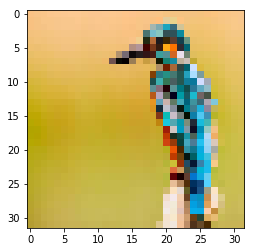

Input image shape: (1, 32, 32, 3)
[[ 0.33666825  0.66333181]]
Not Flower


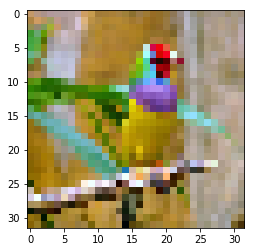

Input image shape: (1, 32, 32, 3)
[[ 0.26569927  0.73430079]]
Not Flower


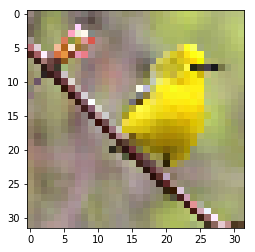

Input image shape: (1, 32, 32, 3)
[[ 0.37302056  0.62697947]]
Not Flower


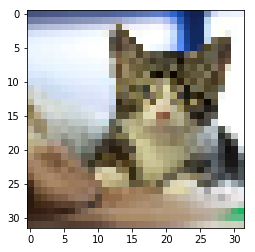

Input image shape: (1, 32, 32, 3)
[[ 0.25434339  0.74565661]]
Not Flower


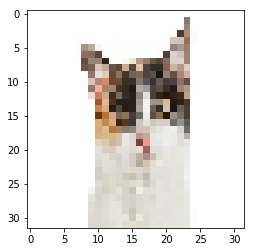

Input image shape: (1, 32, 32, 3)
[[ 0.10166921  0.89833087]]
Not Flower


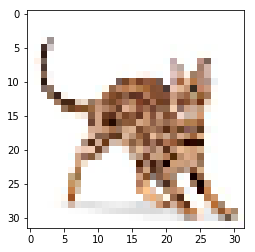

Input image shape: (1, 32, 32, 3)
[[ 0.11845987  0.88154012]]
Not Flower


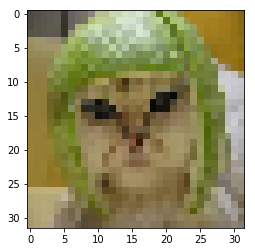

Input image shape: (1, 32, 32, 3)
[[ 0.24180388  0.75819618]]
Not Flower


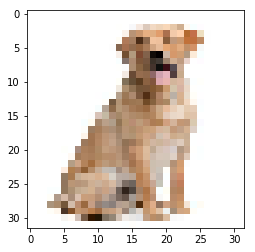

Input image shape: (1, 32, 32, 3)
[[ 0.12217288  0.87782711]]
Not Flower


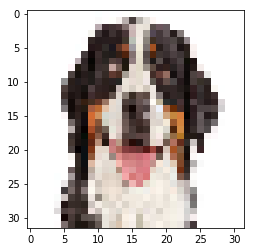

Input image shape: (1, 32, 32, 3)
[[ 0.06966394  0.93033612]]
Not Flower


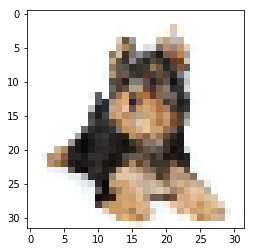

Input image shape: (1, 32, 32, 3)
[[ 0.06540765  0.93459231]]
Not Flower


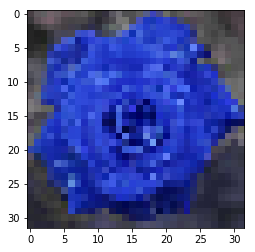

Input image shape: (1, 32, 32, 3)
[[ 0.52534974  0.47465029]]
Flower


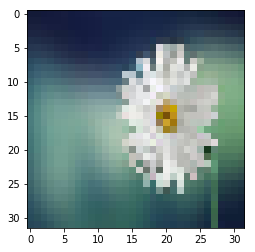

Input image shape: (1, 32, 32, 3)
[[ 0.65268642  0.34731352]]
Flower


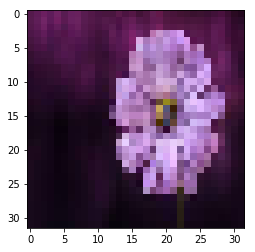

Input image shape: (1, 32, 32, 3)
[[ 0.72100514  0.27899489]]
Flower


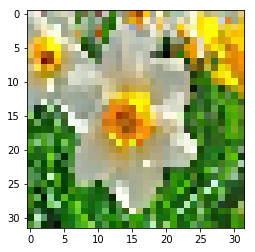

Input image shape: (1, 32, 32, 3)
[[ 0.63312602  0.36687398]]
Flower


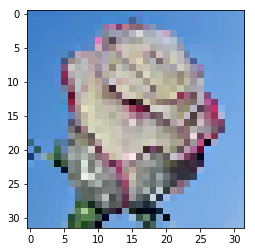

Input image shape: (1, 32, 32, 3)
[[ 0.46958256  0.53041744]]
Not Flower


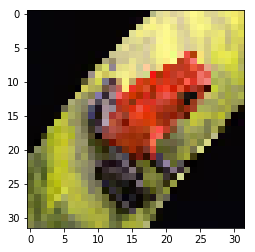

Input image shape: (1, 32, 32, 3)
[[ 0.64345419  0.35654587]]
Flower


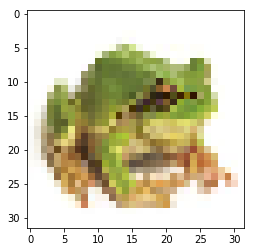

Input image shape: (1, 32, 32, 3)
[[ 0.07091215  0.92908788]]
Not Flower


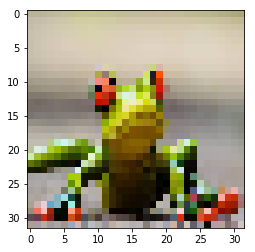

Input image shape: (1, 32, 32, 3)
[[ 0.35763302  0.64236695]]
Not Flower


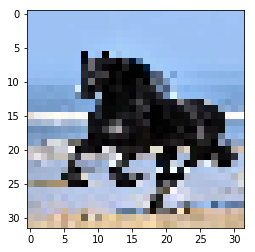

Input image shape: (1, 32, 32, 3)
[[ 0.08733953  0.91266042]]
Not Flower


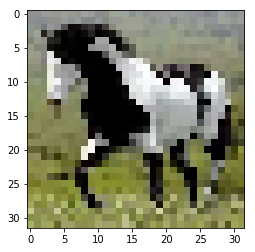

Input image shape: (1, 32, 32, 3)
[[ 0.3844505  0.6155495]]
Not Flower


In [19]:
#-------------------------------Predict my own images - Transfer learning--------------------------------------------------
img_dir = "images_transfer"
img_resize_dir = "img_resized_transfer"

names = ['Flower', 'Not Flower']
for img in os.listdir(img_dir):
    img_path = os.path.join(img_dir, img)
    output_img_path = os.path.join(img_resize_dir, img)
    
    input_array = resize_to_input_and_save(input_image_path=img_path,
                                             output_image_path=output_img_path,
                                             size=(32, 32))
    
    result = new_model.predict(input_array)
    print(result)
    # Prints the name of the class, by getting the max prob from the prediction
    # which is returned as a list with 1 item which is the index
    # and using that index in the wanted classes list
    print(names[np.argmax(result, axis=-1)[0]])

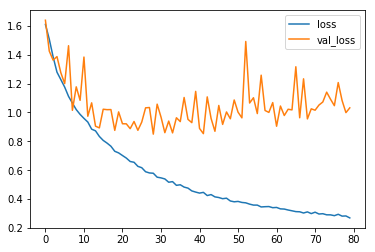

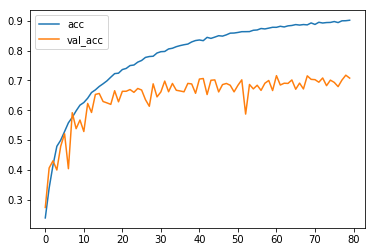

5000/5000 [==============================] - 1s 132us/step
==> Test loss: 1.04746534395
==> Test accuracy: 0.7094


In [20]:
#------------------------------------------------------Second model----------------------------------------------------------
batch_size = 256
epochs = 80

# The data, shuffled and split between train and test sets:
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, (7, 7), padding='same',
               input_shape=x_train.shape[1:], name="Conv.1_32_7-7"))
model.add(Activation('relu', name="relu.1"))
model.add(Conv2D(32, (7, 7), name="Conv.2_32_7-7"))
model.add(Activation('relu', name='relu.2'))
model.add(MaxPooling2D(pool_size=(3, 3), name="MaxPool.1_3-3"))
model.add(Dropout(0.25, name="Dropout.1_0.25"))

model.add(Conv2D(64, (5, 5), padding='same', name="Conv.3_64_5-5"))
model.add(Activation('relu', name="relu.3"))
model.add(Conv2D(64, (5, 5), name="Conv.4_64_5-5"))
model.add(Activation('relu', name="relu.4"))
model.add(MaxPooling2D(pool_size=(2, 2), name="MaxPool.2_2-2"))
model.add(Dropout(0.4, name="Dropout.2_0.4"))

model.add(Flatten())
model.add(Dense(512, name="Dense.1_512"))
model.add(Activation('relu', name="relu.5"))
model.add(Dense(512, name="Dense.2_512"))
model.add(Activation('relu', name="relu.6"))
model.add(Dropout(0.5, name="Dropout.3_0.5"))
model.add(Dense(num_classes, name="Dense.3_5"))
model.add(Activation('softmax', name="Softmax"))

# initiate RMSprop optimizer
rmsprop = keras.optimizers.rmsprop(lr=0.0008, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=rmsprop,
              metrics=['accuracy'])

history = model.fit(x_train, y_train,  # this is our training examples & labels
                      batch_size=batch_size,
                      epochs=epochs,
                      validation_split=0.2,  # this parameter control the % of train data used for validation
                      shuffle=True,
                      callbacks=[plot_losses])  # this prints our loss at the end of every epoch   
    
# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('==> Test loss:', scores[0])
print('==> Test accuracy:', scores[1])

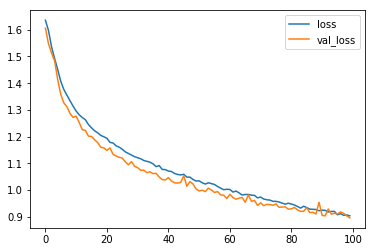

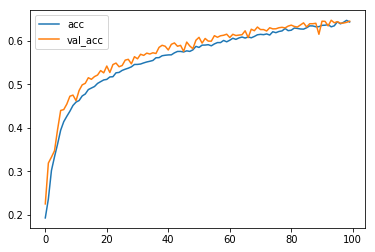

5000/5000 [==============================] - 1s 127us/step
==> Test loss: 0.893791835117
==> Test accuracy: 0.649


In [10]:
#------------------------------------------------------Second model----------------------------------------------------------
batch_size = 128
epochs = 100

# The data, shuffled and split between train and test sets:
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, (5, 5), padding='same',
               input_shape=x_train.shape[1:], name="Conv.1_32_5-5"))
model.add(Activation('relu', name="relu.1"))
model.add(Conv2D(32, (7, 7), name="Conv.2_32_7-7"))
model.add(Activation('relu', name='relu.2'))
model.add(MaxPooling2D(pool_size=(2, 2), name="MaxPool.1_2-2"))
model.add(Dropout(0.25, name="Dropout.1_0.25"))

model.add(Conv2D(32, (3, 3), padding='same', name="Conv.3_32_3-3"))
model.add(Activation('relu', name="relu.3"))
model.add(Conv2D(32, (3, 3), name="Conv.4_32_3-3"))
model.add(Activation('sigmoid', name="sigmoid.4"))
model.add(MaxPooling2D(pool_size=(4, 4), name="MaxPool.2_4-4"))
model.add(Dropout(0.4, name="Dropout.2_0.4"))

model.add(Flatten())
model.add(Dense(512, name="Dense.1_512"))
model.add(Activation('relu', name="relu.5"))
model.add(Dense(512, name="Dense.2_512"))
model.add(Activation('relu', name="relu.6"))
model.add(Dropout(0.5, name="Dropout.3_0.5"))
model.add(Dense(num_classes, name="Dense.3_5"))
model.add(Activation('softmax', name="Softmax"))

# initiate Adam optimizer
adam = keras.optimizers.Adam(lr=0.0001)

# Let's train the model using Adam
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

history = model.fit(x_train, y_train,  # this is our training examples & labels
                      batch_size=batch_size,
                      epochs=epochs,
                      validation_split=0.2,  # this parameter control the % of train data used for validation
                      shuffle=True,
                      callbacks=[plot_losses])  # this prints our loss at the end of every epoch   
    
# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('==> Test loss:', scores[0])
print('==> Test accuracy:', scores[1])